# Imports

In [2]:
import itertools
import copy
from collections import namedtuple

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset

%matplotlib inline

# Bulk data concatenation

In [8]:
data_path = "../training_data/"
data_levelsets = ["train1", "train2", "train3", "train4"]
data_levels = range(1, 990+1)
observation_ext = "observation.zip"
feature_ext = "feature.zip"

def _addRowAndCol(feature_tensor):
    # 3xnxn -> 3x(n+1)x(n+1)
    n = feature_tensor.size()[1]
    channels = []
    new_col = torch.zeros(n, 1)
    new_row = torch.zeros(1, n+1)
    for channel in feature_tensor:
        output_tensor = torch.cat((channel, new_col), dim=1)
        output_tensor = torch.cat((output_tensor, new_row), dim=0)
        channels.append(output_tensor)
    return torch.stack(channels)
    

def dataGatherOnlyObservedSolutions():
    features = []
    observations = []
    for levelset, levelnum in itertools.product(*[data_levelsets, data_levels]):
        level_feature_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, feature_ext)
        level_observation_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, observation_ext)
        
        level_features = torch.load(level_feature_path)
        level_observations = torch.load(level_observation_path)
        
        for feat, obs in zip(level_features, level_observations):
            if obs[1] == 1:
#                 features.append(feat.clone())
                features.append(_addRowAndCol(feat.clone()))
                observations.append(torch.tensor([obs[0].clone()], dtype=torch.float32))
        del level_features
        del level_observations
                
    return torch.stack(features), torch.stack(observations)

# Data Preprocessing and Standardizing
- Features are standardized to mean 0 and std 1
- Observations are normalzed to range [0,1]

In [18]:
def preprocessFeatures(features):
    # features is shape [N, 2, 39, 39]
    # permute to channel is top most axis
    temp_feats = features.clone().permute(*[i for i in range(1, len(features.shape))], 0).contiguous()
    # Calculate mean/std for standardization
    mean = temp_feats.view(2, -1).mean(dim=1)
    std = temp_feats.view(2, -1).std(dim=1)
    # Normalize original features
    for f in features:
        for i, (mu, sigma) in enumerate(zip(mean.tolist(), std.tolist())):
            f[i].sub_(mu)
            f[i].div_(sigma)
    
    return features

def preprocessObservations(observations):
    return torch.log(observations)
#     return observations / max(observations)
#     return torch.log(observations) / max(torch.log(observations))

def getDataLoader(features, observations, batch_size=64):
    data = [(feat, obs) for feat, obs in zip(features, observations)]
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        

# Model

In [4]:
class DisNetCNN(nn.Module):
    def __init__(self, n_depth1=32, f_depth1=64, drop_value=0.15):
        super().__init__()
        ks1 = 3
        ks2 = 3
        ks3 = 1
        
#         conv1_depth = 16
#         conv2_depth = 32
        
        # convolution layers
        self.conv1 = nn.Conv2d(2, n_depth1, kernel_size=ks1, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(n_depth1, n_depth1 // 2, kernel_size=ks2, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(n_depth1 // 2, n_depth1 // 2, kernel_size=ks3, stride=1, padding=0)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        
        # pooling
        self.maxPool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(drop_value)
        
        self.batchnorm1 = nn.BatchNorm2d(n_depth1)
        self.batchnorm2 = nn.BatchNorm2d(n_depth1 // 2)
#         self.avgPool = nn.AveragePool2d(2, 2)
        # subsampling
        
        # FC
        self.fc1 = nn.Linear(40*40*n_depth1 // 2, f_depth1)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(f_depth1, 1)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
#         self.fc3 = nn.Linear(32, 1)
#         torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(F.relu(self.conv3(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    
    def toStr(self):
        return "DisNet"
    
    


In [5]:
class FCN(nn.Module):
    def __init__(self, fc1_size=64, fc2_size=32):
        super().__init__()
        self.dropout = nn.Dropout2d(0.0)
        
        self.fc1 = nn.Linear(40*40*2, fc1_size)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_size, 1)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def toStr(self):
        return "FCN"

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
# model.apply(weight_init)
# torch.manual_seed(your_seed)

# Training loop

In [7]:
default_options = {'n_epochs' : 100, 'batch_size' : 64, 'start_rate' : 1e-3, 'end_rate' : 1e-5, 
                          'clip_gradient_norm' : 1e-2, 'loss_fn' : nn.MSELoss(), 'verbose' : False
                  }

In [27]:
# def train(features, observations, options=default_options):
def train(model, device, train_loader, validation_loader, options=default_options):
    
    # Reset model
    model.apply(weights_init)
    
    # Set device
    model.to(device)
    
    # Get training attributes from options
    loss_fn = options['loss_fn']
    start_rate = options['start_rate']
    end_rate = options['end_rate']
    n_epochs = options['n_epochs']
    clip_gradient_norm = options['clip_gradient_norm']
#     loss_fn = nn.NLLLoss()
    
    # Optimizers
    # - learning rate start 1e-3 to end 1e-5 [done]
    # - gradient clipping [done]
    # - tanh activation function
    # - SGD [done]
    # - batch normalization (as a layer)
    # - L2 regularization of 1e-4
    decay_rate = np.exp(np.log(end_rate / start_rate) / n_epochs)
    
    optimizer = optim.SGD(model.parameters(), lr=start_rate)
#     optimizer = optim.SGD(model.parameters(), lr=start_rate, weight_decay=0.01)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    
    loss_values = []
    for epoch in range(n_epochs):
        training_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Propogate input to model and calculate loss
            batch_size = inputs.shape[0]
            outputs = model(inputs)
            loss = loss_fn(outputs, rts)
            
            # Add l2 loss
            
            # Clip the gradients
            if clip_gradient_norm != None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient_norm)
            
            # Propogate loss backwards and step optimizer
            loss.backward()
            optimizer.step()
            
#             running_loss =+ loss.item() * inputs.size(0)
            training_loss += loss.item()
            
        # Get validation loss
        validation_loss = 0.0
        model.eval()
        for i, data in enumerate(validation_loader):
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, rts)
            validation_loss += loss.item()
            
        # Store training and validation loss
#         loss_values.append((training_loss / len(train_loader), validation_loss / len(validation_loader)))
        loss_values.append((epoch, training_loss / len(train_loader), 'Train', model.toStr()))
        loss_values.append((epoch, validation_loss / len(validation_loader), 'Test', model.toStr()))
        if options['verbose'] and epoch % 10 == 9: 
            print("Epoch: {:d}, Training Loss {:f}, Validation Loss {:f}".format(epoch+1, float(loss_values[-2][1]), float(loss_values[-1][1])))
        
        # Update learning rate
        lr_scheduler.step()
    return loss_values, model

# Testing

### Single set validation

In [9]:
def validate(features, observations, model, options=default_options):
    # Preprocess input
    features = preprocessFeatures(features)
    observations = preprocessObservations(observations)
    
    # Create dataloader
    test_loader = getDataLoader(features, observations, options.batch_size)
    
    # Don't need to backprop during testing
    with torch.no_grad():
        for i, data in enumerate(test_loader):
             # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)   

### K-Fold Validation

In [10]:
def kfoldValidation(features, observations, options, model, num_folds=5):
    # Get training attributes from options
    batch_size = options['batch_size']
    loss_fn = options['loss_fn']
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
    loss_data = []
    
    for fold_count, (training_idx, test_idx) in enumerate(kf.split(features)):
        print('Fold {}'.format(fold_count+1))
        
        # Split data
        train_features, test_features = features[training_idx,:], features[test_idx,:]
        train_observations, test_observations = observations[training_idx,:], observations[test_idx,:]
        
        # Create dataloaders
        train_loader = getDataLoader(train_features, train_observations, batch_size)
        test_loader = getDataLoader(test_features, test_observations, batch_size)
        
        # Train model
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        run_loss, _ = train(model, device, train_loader, test_loader, options)
        loss_data += run_loss
#         print("{} {}".format(len(run_loss), len(loss_data)))
        
        # Test 
        # Don't need to backprop during testing
#         test_loss = 0.0
#         with torch.no_grad():
#             for data in test_loader:
#                 inputs, rts = data
#                 inputs, rts = inputs.to(device), rts.to(device)  
#                 outputs = model(inputs)
#                 loss = loss_fn(outputs, rts)
#                 test_loss += loss.item()
                
        # Save avg loss
#         loss_data.append(run_loss)
#         test_losses.append(test_loss / len(test_loader))
        
    # Average losses
    return loss_data
        

# Util and Graphing

In [11]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Main Scripts

### FNN Model Gridsearch

In [ ]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 400
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6



# Gridsearch options
param_grid = {'batch_size': [16, 32, 64], 
              'l_rates' : [(1e-3, 1e-4), (1e-3, 1e-5), (1e-3, 1e-6), (1e-3, 1e-7),
                           (1e-4, 1e-5), (1e-4, 1e-6), (1e-4, 1e-7), (1e-5, 1e-6),
                           (1e-5, 1e-7), (1e-6, 1e-7)],
              'fc1': [16, 32, 64, 128],
              'fc2': [16, 32, 64, 128],
             }

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Run gridsearch
results = []
for i, params in enumerate(ParameterGrid(param_grid)):
    if i % 10 == 9: print(i+1)
    current_options = copy.deepcopy(base_options)
    # Set params
    current_options['batch_size'] = params['batch_size']
    current_options['start_rate'] = params['l_rates'][0]
    current_options['end_rate'] = params['l_rates'][1]
    model = FCN(params['fc1'], params['fc2'])
    
    # Run K-fold
    results.append((kfoldValidation(features, observations, current_options, model), current_options))
    
# Print results
print(sorted(results, key=lambda x : x[0], reverse=True)[:10])

### Single K-fold test

In [114]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 400
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6



# Gridsearch options
param_grid = {'fcn_i' : [(128, 128), (128, 64), (128, 32), (64, 64),
                           (64, 32), (32, 32)]
             }

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Run gridsearch
results = []
for i, params in enumerate(ParameterGrid(param_grid)):
    current_options = copy.deepcopy(base_options)
    current_options['fcn_i'] = params['fcn_i']
    # Set params
#     current_options['batch_size'] = params['batch_size']
#     current_options['start_rate'] = params['l_rates'][0]
#     current_options['end_rate'] = params['l_rates'][1]
    model = FCN(128, 32)
    
    # Run K-fold
    results.append((kfoldValidation(features, observations, current_options, model), current_options))
    
# Print results
for l in sorted(results, key=lambda x : x[0]):
    print(l)
# print(sorted(results, key=lambda x : x[0]))

(0.9618216724693776, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 32)})
(0.9662183678150175, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 64)})
(1.009751491546631, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (128, 128)})
(1.024035993695259, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (64, 32)})
(1.1157941100001334, {'n_epochs': 400, 'batch_size': 16, 'start_rate': 0.0001, 'end_rate': 1e-06, 'clip_gradient_norm': 0.01, 'loss_fn': MSELoss(), 'verbose': False, 'fcn_i': (32, 32)})
(1.1432155785560607, {'n_epochs': 400, 'batch_size': 16, 'start_rate

In [26]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
current_options = copy.deepcopy(default_options)
current_options['n_epochs'] = 250
current_options['batch_size'] = 16
current_options['start_rate'] = 1e-4
current_options['end_rate'] = 1e-6
current_options['verbose'] = True
current_options['loss_fn'] = nn.MSELoss(reduction='none')

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

device = torch.device("cuda:0")
model = DisNetCNN()
# model = FCN(64, 32)

# Dataframe
columns = ['Epoch', 'Loss', 'Run Type', 'Model']
df1 = pd.DataFrame(columns=columns)

# Run kfold and add data to df
loss_data = kfoldValidation(features, observations, current_options, model, 2)
for row in loss_data:
    df1 = df1.append(pd.Series(row, index=df1.columns), ignore_index=True)

Fold 1
tensor([[1.3232e+01],
        [4.8045e-01],
        [3.8064e+01],
        [3.4449e+01],
        [1.6626e+01],
        [1.9218e+00],
        [4.8045e-01],
        [4.8045e-01],
        [1.7759e+01],
        [3.4395e-02],
        [4.3396e+01],
        [2.4206e+01],
        [4.8045e-01],
        [1.0615e+01],
        [4.8045e-01],
        [4.8045e-01]], device='cuda:0', grad_fn=<MseLossBackward>)
12.69914722442627


TypeError: cannot unpack non-iterable NoneType object

In [24]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training base options
current_options = copy.deepcopy(default_options)
current_options['n_epochs'] = 250
current_options['batch_size'] = 16
current_options['start_rate'] = 1e-4
current_options['end_rate'] = 1e-6
current_options['verbose'] = True

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

device = torch.device("cuda:0")
# model = DisNetCNN()
model = FCN(64, 32)

# Dataframe
columns = ['Epoch', 'Loss', 'Run Type', 'Model']
df2 = pd.DataFrame(columns=columns)

# Run kfold and add data to df
loss_data = kfoldValidation(features, observations, current_options, model, 5)
for row in loss_data:
    df2 = df2.append(pd.Series(row, index=df2.columns), ignore_index=True)

Fold 1
Epoch: 10, Training Loss 0.097623, Validation Loss 0.100865
Epoch: 20, Training Loss 0.071147, Validation Loss 0.075855
Epoch: 30, Training Loss 0.058447, Validation Loss 0.064230
Epoch: 40, Training Loss 0.052262, Validation Loss 0.058435
Epoch: 50, Training Loss 0.048118, Validation Loss 0.053494
Epoch: 60, Training Loss 0.045428, Validation Loss 0.051161
Epoch: 70, Training Loss 0.043544, Validation Loss 0.049567
Epoch: 80, Training Loss 0.042234, Validation Loss 0.048204
Epoch: 90, Training Loss 0.041230, Validation Loss 0.047540
Epoch: 100, Training Loss 0.040489, Validation Loss 0.046597
Epoch: 110, Training Loss 0.039913, Validation Loss 0.046427
Epoch: 120, Training Loss 0.039458, Validation Loss 0.046155
Epoch: 130, Training Loss 0.039077, Validation Loss 0.045509
Epoch: 140, Training Loss 0.038760, Validation Loss 0.045225
Epoch: 150, Training Loss 0.038504, Validation Loss 0.045082
Epoch: 160, Training Loss 0.038301, Validation Loss 0.045105
Epoch: 170, Training Loss 

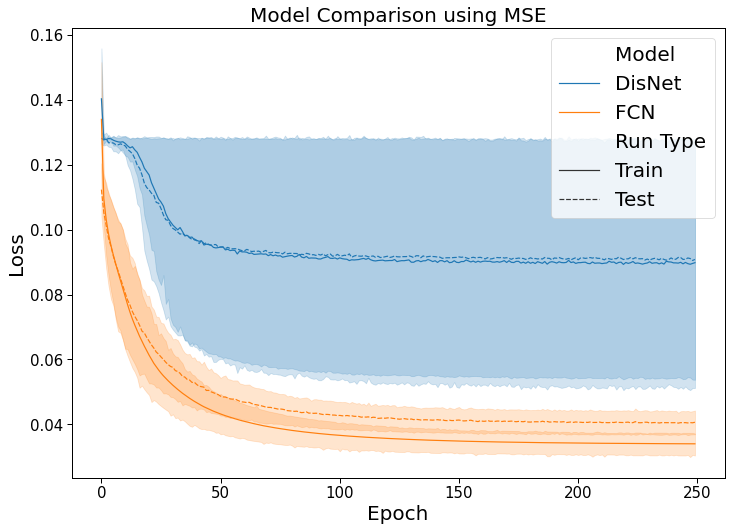

In [26]:
# Join dataframes
df = df1.append(df2, ignore_index=True)
# df = df2

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, 
                             'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 20}) 
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax.set_title("Model Comparison using MSE")
g = sns.lineplot(x="Epoch", y="Loss", hue="Model", style="Run Type", data=df)
fig.savefig('ModelCompare2.png', facecolor=fig.get_facecolor())

In [12]:
# Get data
features = torch.load('train_nokey_only_solution_feats.pt')
observations = torch.load('train_nokey_only_solution_obs.pt')

# Training options
# options = Options(n_epochs=400, batch_size=32, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=None, verbose=True)
# Training base options
base_options = copy.deepcopy(default_options)
base_options['n_epochs'] = 250
base_options['batch_size'] = 16
base_options['start_rate'] = 1e-4
base_options['end_rate'] = 1e-6
base_options['verbose'] = True

# preprocess
features = preprocessFeatures(features)
observations = preprocessObservations(observations)

# Split into train/test
indices = np.random.permutation(features.shape[0])
training_idx, validation_idx = indices[:80], indices[80:]
train_features, validation_features = features[training_idx,:], features[validation_idx,:]
train_observations, validation_observations = observations[training_idx,:], observations[validation_idx,:]

# device and model
device = torch.device("cuda:0")
model = DisNetCNN()
# model = FCN(64, 32)

# Create dataloaders
train_loader = getDataLoader(train_features, train_observations, base_options['batch_size'])
validation_loader = getDataLoader(validation_features, validation_observations,  base_options['batch_size'])

loss_values, model = train(model, device, train_loader, validation_loader, base_options)

Epoch: 10, Training Loss 3.322473, Validation Loss 5.831458
Epoch: 20, Training Loss 1.590233, Validation Loss 4.471516
Epoch: 30, Training Loss 1.761914, Validation Loss 4.260561
Epoch: 40, Training Loss 1.030290, Validation Loss 4.307520
Epoch: 50, Training Loss 1.109307, Validation Loss 4.299621
Epoch: 60, Training Loss 0.856583, Validation Loss 4.185945
Epoch: 70, Training Loss 0.697775, Validation Loss 4.303351
Epoch: 80, Training Loss 0.773177, Validation Loss 3.996835
Epoch: 90, Training Loss 0.706422, Validation Loss 4.000605
Epoch: 100, Training Loss 0.554376, Validation Loss 4.200604
Epoch: 110, Training Loss 0.593429, Validation Loss 4.100554
Epoch: 120, Training Loss 1.132880, Validation Loss 4.053129
Epoch: 130, Training Loss 0.662114, Validation Loss 4.069253
Epoch: 140, Training Loss 0.600412, Validation Loss 4.085588
Epoch: 150, Training Loss 0.728760, Validation Loss 4.033118
Epoch: 160, Training Loss 0.724881, Validation Loss 4.020287
Epoch: 170, Training Loss 0.53825

In [19]:
with torch.no_grad():
    for data in validation_loader:
        inputs, rts = data
        inputs, rts = inputs.to(device), rts.to(device)  
        outputs = model(inputs)
        for a, b in zip(outputs, rts):
            a_ = a.data.cpu().numpy()[0]
            b_ = b.data.cpu().numpy()[0]
            print('Pred {:.3f}, Obs {:.3f}, Delta {:.3f}'.format(a_, b_, abs(a_ - b_)))

Pred 5.115, Obs 4.407, Delta 0.709
Pred 5.351, Obs 4.443, Delta 0.908
Pred 1.974, Obs 0.693, Delta 1.281
Pred 3.873, Obs 5.989, Delta 2.116
Pred 3.355, Obs 4.454, Delta 1.099
Pred 0.000, Obs 0.693, Delta 0.693
Pred 4.986, Obs 5.088, Delta 0.101
Pred 1.152, Obs 0.693, Delta 0.459
Pred 2.955, Obs 0.693, Delta 2.262
Pred 1.581, Obs 0.693, Delta 0.888
Pred 4.570, Obs 5.940, Delta 1.370
Pred 5.556, Obs 5.442, Delta 0.113
Pred 1.497, Obs 0.693, Delta 0.804
Pred 1.103, Obs 1.099, Delta 0.004
Pred 5.303, Obs 7.039, Delta 1.736
Pred 6.425, Obs 7.540, Delta 1.115
Pred 5.793, Obs 4.970, Delta 0.824
Pred 5.062, Obs 3.689, Delta 1.373
Pred 1.035, Obs 0.693, Delta 0.342
Pred 4.983, Obs 6.098, Delta 1.115
Pred 4.414, Obs 4.956, Delta 0.542
Pred 0.855, Obs 0.693, Delta 0.162
Pred 1.886, Obs 3.258, Delta 1.372
Pred 2.740, Obs 3.466, Delta 0.726
Pred 0.766, Obs 0.693, Delta 0.073
Pred 2.897, Obs 4.868, Delta 1.971
Pred 2.796, Obs 0.693, Delta 2.103
Pred 4.242, Obs 2.833, Delta 1.409
Pred 1.724, Obs 0.69

Pred 2.857, Obs 0.693, Delta 2.164
Pred 1.146, Obs 1.792, Delta 0.646
Pred 0.358, Obs 3.871, Delta 3.514
Pred 1.199, Obs 0.693, Delta 0.506
Pred 4.091, Obs 4.883, Delta 0.792
Pred 4.185, Obs 3.584, Delta 0.601
Pred 4.780, Obs 5.209, Delta 0.430
Pred 2.380, Obs 5.263, Delta 2.883
Pred 1.231, Obs 0.693, Delta 0.538
Pred 0.216, Obs 0.693, Delta 0.477
Pred 3.572, Obs 0.693, Delta 2.879
Pred 4.976, Obs 4.754, Delta 0.223
Pred 3.515, Obs 0.693, Delta 2.822
Pred 5.270, Obs 4.787, Delta 0.483
Pred 3.424, Obs 7.292, Delta 3.868
Pred 4.544, Obs 6.768, Delta 2.224
Pred 5.478, Obs 3.689, Delta 1.789
Pred 1.350, Obs 1.386, Delta 0.036
Pred 3.614, Obs 5.645, Delta 2.032
Pred 0.098, Obs 0.693, Delta 0.595
Pred 1.734, Obs 0.693, Delta 1.041
Pred 1.321, Obs 1.099, Delta 0.222
Pred 3.782, Obs 4.248, Delta 0.467
Pred 6.492, Obs 6.868, Delta 0.376
Pred 1.805, Obs 5.787, Delta 3.982
Pred 1.942, Obs 0.693, Delta 1.249
Pred 2.143, Obs 3.584, Delta 1.441
Pred 0.495, Obs 0.000, Delta 0.495
Pred 4.132, Obs 4.26

Pred 2.157, Obs 3.638, Delta 1.481
Pred 0.814, Obs 3.434, Delta 2.620
Pred 5.002, Obs 0.693, Delta 4.309
Pred 2.014, Obs 0.693, Delta 1.321
Pred 2.132, Obs 0.693, Delta 1.439
Pred 5.073, Obs 4.564, Delta 0.509
Pred 2.665, Obs 4.868, Delta 2.202
Pred 1.603, Obs 0.693, Delta 0.910
Pred 6.022, Obs 5.606, Delta 0.416
Pred 0.760, Obs 0.000, Delta 0.760
Pred 2.416, Obs 0.693, Delta 1.723
Pred 2.566, Obs 1.792, Delta 0.774
Pred 0.913, Obs 0.693, Delta 0.220
Pred 1.472, Obs 3.829, Delta 2.357
Pred 2.163, Obs 9.833, Delta 7.669
Pred 0.917, Obs 0.693, Delta 0.224
Pred 2.387, Obs 2.079, Delta 0.307
Pred 3.804, Obs 3.401, Delta 0.402
Pred 4.733, Obs 7.299, Delta 2.566
Pred 5.118, Obs 0.693, Delta 4.424
Pred 2.964, Obs 0.693, Delta 2.270
Pred 3.917, Obs 7.462, Delta 3.545
Pred 2.480, Obs 0.693, Delta 1.787
Pred 3.706, Obs 3.784, Delta 0.079
Pred 1.156, Obs 5.938, Delta 4.781
Pred 2.216, Obs 0.693, Delta 1.523
Pred 3.415, Obs 0.693, Delta 2.722
Pred 2.406, Obs 1.609, Delta 0.796
Pred 6.046, Obs 9.61

Pred 3.245, Obs 3.178, Delta 0.067
Pred 4.669, Obs 0.693, Delta 3.976
Pred 0.703, Obs 0.693, Delta 0.009
Pred 3.662, Obs 5.069, Delta 1.407
Pred 3.487, Obs 5.659, Delta 2.173
Pred 2.057, Obs 0.693, Delta 1.364
Pred 1.309, Obs 0.693, Delta 0.616
Pred 2.222, Obs 4.205, Delta 1.983
Pred 0.982, Obs 0.693, Delta 0.289
Pred 3.963, Obs 7.991, Delta 4.028
Pred 2.947, Obs 2.565, Delta 0.382
Pred 1.421, Obs 6.151, Delta 4.730
Pred 1.095, Obs 0.693, Delta 0.402
Pred 1.051, Obs 0.693, Delta 0.358
Pred 2.021, Obs 0.693, Delta 1.328
Pred 0.916, Obs 0.693, Delta 0.223
Pred 3.913, Obs 4.369, Delta 0.456
Pred 1.827, Obs 0.693, Delta 1.134
Pred 1.091, Obs 4.575, Delta 3.484
Pred 2.218, Obs 3.829, Delta 1.611
Pred 2.890, Obs 2.944, Delta 0.054
Pred 5.298, Obs 3.689, Delta 1.609
Pred 3.342, Obs 6.312, Delta 2.970
Pred 6.268, Obs 6.668, Delta 0.400
Pred 5.253, Obs 5.375, Delta 0.122
Pred 3.942, Obs 5.394, Delta 1.451
Pred 3.422, Obs 3.497, Delta 0.075
Pred 3.968, Obs 5.130, Delta 1.162
Pred 4.987, Obs 4.33

Pred 2.302, Obs 4.431, Delta 2.129
Pred 2.622, Obs 0.693, Delta 1.929
Pred 0.373, Obs 3.526, Delta 3.154
Pred 1.579, Obs 2.079, Delta 0.501
Pred 5.002, Obs 7.779, Delta 2.778
Pred 3.598, Obs 2.565, Delta 1.033
Pred 4.043, Obs 6.600, Delta 2.557
Pred 1.635, Obs 0.693, Delta 0.942
Pred 2.265, Obs 3.091, Delta 0.826
Pred 4.357, Obs 3.871, Delta 0.486
Pred 5.189, Obs 5.153, Delta 0.036
Pred 2.286, Obs 0.693, Delta 1.593
Pred 0.617, Obs 3.638, Delta 3.021
Pred 4.326, Obs 5.628, Delta 1.301
Pred 4.174, Obs 3.526, Delta 0.647
Pred 0.000, Obs 0.000, Delta 0.000
Pred 2.652, Obs 5.572, Delta 2.920
Pred 2.751, Obs 0.693, Delta 2.057
Pred 0.000, Obs 0.000, Delta 0.000
Pred 2.936, Obs 4.078, Delta 1.141
Pred 0.716, Obs 2.708, Delta 1.992
Pred 5.021, Obs 6.681, Delta 1.660
Pred 5.254, Obs 4.407, Delta 0.847
Pred 3.662, Obs 5.849, Delta 2.187
Pred 0.076, Obs 4.094, Delta 4.019
Pred 4.560, Obs 5.380, Delta 0.820
Pred 2.264, Obs 3.871, Delta 1.608
Pred 1.580, Obs 0.693, Delta 0.887
Pred 1.664, Obs 0.69

Pred 3.818, Obs 4.060, Delta 0.242
Pred 5.018, Obs 3.784, Delta 1.234
Pred 5.032, Obs 5.966, Delta 0.934
Pred 3.627, Obs 2.944, Delta 0.683
Pred 4.281, Obs 1.386, Delta 2.894
Pred 2.277, Obs 0.693, Delta 1.584
Pred 0.054, Obs 0.693, Delta 0.639
Pred 3.031, Obs 0.693, Delta 2.338
Pred 4.482, Obs 5.635, Delta 1.153
Pred 2.469, Obs 0.693, Delta 1.776
Pred 0.000, Obs 0.000, Delta 0.000
Pred 1.717, Obs 0.693, Delta 1.023
Pred 0.731, Obs 2.708, Delta 1.977
Pred 4.874, Obs 5.966, Delta 1.092
Pred 0.000, Obs 0.693, Delta 0.693
Pred 0.201, Obs 1.099, Delta 0.897
Pred 3.923, Obs 6.899, Delta 2.976
Pred 2.636, Obs 0.693, Delta 1.943
Pred 3.400, Obs 0.693, Delta 2.706
Pred 3.679, Obs 4.860, Delta 1.181
Pred 1.009, Obs 0.693, Delta 0.316
Pred 1.600, Obs 0.693, Delta 0.907
Pred 0.426, Obs 0.693, Delta 0.267
Pred 4.418, Obs 3.091, Delta 1.327
Pred 2.299, Obs 3.091, Delta 0.792
Pred 4.744, Obs 9.463, Delta 4.719
Pred 2.105, Obs 3.135, Delta 1.031
Pred 2.377, Obs 5.278, Delta 2.901
Pred 4.048, Obs 0.69

Pred 1.316, Obs 6.558, Delta 5.242
Pred 5.160, Obs 7.039, Delta 1.879
Pred 3.358, Obs 3.526, Delta 0.168
Pred 1.254, Obs 1.609, Delta 0.355
Pred 3.302, Obs 0.693, Delta 2.609
Pred 1.323, Obs 3.584, Delta 2.260
Pred 3.689, Obs 2.708, Delta 0.981
Pred 1.911, Obs 1.609, Delta 0.302
Pred 1.444, Obs 1.609, Delta 0.165
Pred 4.447, Obs 3.912, Delta 0.535
Pred 0.000, Obs 0.693, Delta 0.693
Pred 0.804, Obs 0.693, Delta 0.110
Pred 2.331, Obs 0.693, Delta 1.637
Pred 0.887, Obs 0.693, Delta 0.194
Pred 2.908, Obs 0.693, Delta 2.215
Pred 2.519, Obs 0.693, Delta 1.826
Pred 0.850, Obs 1.099, Delta 0.248
Pred 2.398, Obs 0.693, Delta 1.705
Pred 2.874, Obs 3.401, Delta 0.527
Pred 3.168, Obs 3.738, Delta 0.570
Pred 2.721, Obs 0.693, Delta 2.028
Pred 4.963, Obs 7.100, Delta 2.137
Pred 1.589, Obs 4.277, Delta 2.687
Pred 4.964, Obs 4.382, Delta 0.582
Pred 4.139, Obs 9.595, Delta 5.456
Pred 5.227, Obs 0.693, Delta 4.534
Pred 3.325, Obs 0.693, Delta 2.631
Pred 4.679, Obs 5.323, Delta 0.644
Pred 3.543, Obs 4.40

Pred 4.926, Obs 8.502, Delta 3.577
Pred 1.027, Obs 2.833, Delta 1.806
Pred 1.930, Obs 2.398, Delta 0.468
Pred 2.917, Obs 0.693, Delta 2.224
Pred 3.919, Obs 6.098, Delta 2.179
Pred 1.058, Obs 0.693, Delta 0.364
Pred 2.433, Obs 3.784, Delta 1.351
Pred 2.096, Obs 1.386, Delta 0.710
Pred 4.143, Obs 7.013, Delta 2.870
Pred 3.797, Obs 7.329, Delta 3.533
Pred 1.974, Obs 0.693, Delta 1.281
Pred 0.000, Obs 0.693, Delta 0.693
Pred 2.621, Obs 0.693, Delta 1.928
Pred 2.582, Obs 0.693, Delta 1.888
Pred 1.601, Obs 0.693, Delta 0.908
Pred 1.155, Obs 0.693, Delta 0.461
Pred 1.478, Obs 2.079, Delta 0.601
Pred 6.098, Obs 6.435, Delta 0.337
Pred 0.698, Obs 4.060, Delta 3.362
Pred 1.325, Obs 1.099, Delta 0.226
Pred 1.661, Obs 3.638, Delta 1.976
Pred 1.695, Obs 0.693, Delta 1.002
Pred 2.648, Obs 2.708, Delta 0.060
Pred 1.502, Obs 0.693, Delta 0.809
Pred 0.770, Obs 4.654, Delta 3.884
Pred 4.994, Obs 4.575, Delta 0.419
Pred 2.366, Obs 4.277, Delta 1.911
Pred 4.244, Obs 0.693, Delta 3.551
Pred 1.135, Obs 0.69

Pred 1.549, Obs 3.332, Delta 1.784
Pred 1.085, Obs 0.693, Delta 0.392
Pred 3.543, Obs 5.733, Delta 2.190
Pred 2.426, Obs 0.693, Delta 1.733
Pred 4.773, Obs 4.431, Delta 0.342
Pred 3.438, Obs 3.638, Delta 0.199
Pred 6.240, Obs 7.163, Delta 0.923
Pred 2.030, Obs 3.401, Delta 1.371
Pred 3.413, Obs 3.871, Delta 0.458
Pred 3.759, Obs 9.109, Delta 5.350
Pred 2.394, Obs 0.000, Delta 2.394
Pred 2.322, Obs 3.689, Delta 1.366
Pred 1.808, Obs 4.094, Delta 2.286
Pred 2.037, Obs 0.693, Delta 1.343
Pred 2.722, Obs 0.693, Delta 2.029
Pred 0.664, Obs 0.000, Delta 0.664
Pred 4.669, Obs 7.696, Delta 3.027
Pred 2.450, Obs 0.693, Delta 1.757
Pred 4.019, Obs 2.398, Delta 1.621
Pred 2.698, Obs 0.693, Delta 2.005
Pred 5.337, Obs 5.642, Delta 0.305
Pred 3.314, Obs 4.248, Delta 0.935
Pred 1.048, Obs 0.693, Delta 0.355
Pred 1.583, Obs 0.693, Delta 0.890
Pred 1.015, Obs 4.700, Delta 3.686
Pred 3.744, Obs 7.538, Delta 3.794
Pred 1.572, Obs 0.693, Delta 0.879
Pred 0.947, Obs 0.693, Delta 0.254
Pred 2.103, Obs 0.69

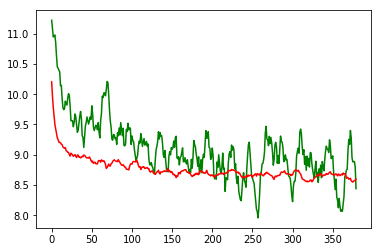

In [130]:
# plt.plot(loss_values)
window_size = 10
plt.plot(smooth([l[0] for l in loss_values], window_size)[window_size:-window_size], 'g')
plt.plot(smooth([l[1] for l in loss_values], window_size)[window_size:-window_size], 'r')

In [236]:
device = torch.device("cuda:0")
index = 1208
f = preprocessFeatures(feats)[index:index+1].to(device)
o = preprocessObservations(obs)[index:index+1]
print(model(f))
print(o)

tensor([[0.]], device='cuda:0', grad_fn=<FeatureDropoutBackward>)
tensor([[3.3673]])


In [172]:
summary(model, (2, 40, 40))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:

# feats, obs = dataGatherOnlyObservedSolutions()
# torch.save(feats, 'train_nokey_only_solution_feats.pt')
# torch.save(obs, 'train_nokey_only_solution_obs.pt')

In [158]:
feats = torch.load('train_nokey_only_solution_feats.pt')
obs = torch.load('train_nokey_only_solution_obs.pt')
print(feats.shape)
print(obs.shape)

torch.Size([3960, 2, 40, 40])
torch.Size([3960, 1])


In [77]:
permTempFeats

tensor([[[[0.2014, 0.8822, 0.1140, 0.8369],
          [0.2918, 0.7020, 0.7541, 0.3556],
          [0.5786, 0.8386, 0.7378, 0.5152],
          [0.9454, 0.2910, 0.9145, 0.5884]],

         [[0.7923, 0.7909, 0.1098, 0.3195],
          [0.4803, 0.4007, 0.6035, 0.5743],
          [0.0171, 0.2761, 0.9388, 0.6652],
          [0.5459, 0.6032, 0.4494, 0.3658]]],


        [[[0.7770, 0.7051, 0.3316, 0.8457],
          [0.2978, 0.7117, 0.1090, 0.3297],
          [0.6302, 0.1306, 0.3089, 0.6453],
          [0.1877, 0.4400, 0.6960, 0.0021]],

         [[0.6115, 0.4842, 0.6426, 0.3837],
          [0.9901, 0.3421, 0.5447, 0.2467],
          [0.8325, 0.7696, 0.2741, 0.2561],
          [0.2276, 0.2711, 0.4679, 0.4610]]],


        [[[0.3534, 0.6828, 0.2816, 0.1926],
          [0.4594, 0.9886, 0.3416, 0.1624],
          [0.8285, 0.4373, 0.4972, 0.4604],
          [0.5750, 0.9687, 0.7848, 0.4529]],

         [[0.0018, 0.5595, 0.9077, 0.3239],
          [0.2525, 0.5788, 0.6479, 0.9415],
          [0.1342,

In [78]:
temp1 = preprocessFeatures(permTempFeats)
print(temp1)

torch.Size([2, 4, 4, 3])
torch.Size([2, 48])
tensor([0.5242, 0.5069])
tensor([0.2678, 0.2553])
tensor([[[[-1.2056,  1.3370, -1.5320,  1.1678],
          [-0.8682,  0.6639,  0.8585, -0.6299],
          [ 0.2030,  1.1740,  0.7977, -0.0338],
          [ 1.5730, -0.8710,  1.4576,  0.2395]],

         [[ 1.1182,  1.1127, -1.5556, -0.7341],
          [-0.1041, -0.4160,  0.3785,  0.2643],
          [-1.9189, -0.9039,  1.6920,  0.6203],
          [ 0.1530,  0.3772, -0.2251, -0.5525]]],


        [[[ 0.9440,  0.6756, -0.7194,  1.2005],
          [-0.8456,  0.7002, -1.5508, -0.7266],
          [ 0.3958, -1.4700, -0.8040,  0.4520],
          [-1.2569, -0.3144,  0.6414, -1.9500]],

         [[ 0.4101, -0.0887,  0.5317, -0.4824],
          [ 1.8931, -0.6453,  0.1483, -1.0191],
          [ 1.2756,  1.0292, -0.9119, -0.9826],
          [-1.0943, -0.9238, -0.1526, -0.1799]]],


        [[[-0.6380,  0.5920, -0.9061, -1.2384],
          [-0.2422,  1.7343, -0.6820, -1.3513],
          [ 1.1363, -0.3245, 

In [52]:
temp1 = [0.2014, 0.8822, 0.1140, 0.8369, 0.2918, 0.7020, 0.7541, 0.3556, 0.5786, 0.8386, 0.7378, 0.5152, 0.9454, 0.2910, 0.9145, 0.5884, \
0.7770, 0.7051, 0.3316, 0.8457, 0.2978, 0.7117, 0.1090, 0.3297, 0.6302, 0.1306, 0.3089, 0.6453, 0.1877, 0.4400, 0.6960, 0.0021, \
0.3534, 0.6828, 0.2816, 0.1926, 0.4594, 0.9886, 0.3416, 0.1624, 0.8285, 0.4373, 0.4972, 0.4604, 0.5750, 0.9687, 0.7848, 0.4529]
sum(temp1) / len(temp1)

0.52423125

In [64]:
transform = transforms.Normalize()

TypeError: __init__() missing 2 required positional arguments: 'mean' and 'std'